<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/sketch_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Environment

In [0]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tensorflow.keras.utils import plot_model
import imageio
from PIL import Image
# from glob import glob

input_folder = "sketch_128"
test_folder = "test_128"
output_folder = "out"


# Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Download and unzip training set

In [0]:
!cp /content/gdrive/'My Drive'/neural/{input_folder}.zip {input_folder}.zip
!unzip {input_folder}.zip

Download and unzip test set

In [0]:
!cp /content/gdrive/'My Drive'/neural/{test_folder}.zip {test_folder}.zip
!unzip {test_folder}.zip

Read images index

In [5]:
sketch_files = os.listdir(f"{input_folder}/sketch")
orig_files = os.listdir(f"{input_folder}/orig")
src_files = sorted(orig_files)
test_files = sorted(os.listdir(f"{test_folder}"))

print(f"{len(sketch_files)} sketches")
print(f"{len(orig_files)} originals")
print(f"{len(test_files)} test files")

files_count = len(sketch_files)
test_files_count = len(test_files)

542 sketches
542 originals
4 test files


In [0]:
def read_image(path):
    try:
        return imageio.imread(path)
    except Exception as e:
        print("Image cannot be read: [%s]" % filename)


In [0]:
!rm -rf sketch_128/orig/.ipynb_checkpoints
!rm -fr sketch_128/sketch/.ipynb_checkpoints


rm: cannot remove 'sketch_128/sketch/cup38.jpg': No such file or directory
rm: cannot remove 'sketch_128/orig/cup39.jpg': No such file or directory


## Dataset Image Example

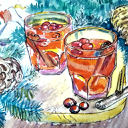

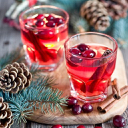

In [11]:
filename = orig_files[105]

im = Image.open(f"{input_folder}/sketch/{filename}")
display(im)

im = Image.open(f"{input_folder}/orig/{filename}")
display(im)

## Image Loader

In [0]:
class DataLoader():
    def __init__(self):
        self.sketch_files = os.listdir(f"{input_folder}/sketch")
        self.orig_files = os.listdir(f"{input_folder}/orig")
        self.test_files = os.listdir("test_128")
        self.files_count = len(self.orig_files)

        
    def reset(self):
        file_indices = np.arange(self.files_count)
        np.random.shuffle(file_indices)
        self.rand_files = np.asarray(self.orig_files)[file_indices]
        
        
    def load_test(self):
        imgs = []
        for f in self.test_files:
            im = self.imread(f"test_128/{f}")
            im = np.array(im)/127.5 - 1.
            imgs.append(im)
        return np.array(imgs)
    

    def load_batch(self, batch_index, batch_size):
        i_from = batch_index * batch_size
        i_to = (batch_index + 1) * batch_size
        batch_files = self.rand_files[i_from : i_to]
        
        imgs_A, imgs_B = [], []
        for f in batch_files:
            imgs_A.append(self.imread(f"{input_folder}/sketch/{f}"))
            imgs_B.append(self.imread(f"{input_folder}/orig/{f}"))

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B


    def imread(self, path):
        return imageio.imread(path).astype(np.float)

# Model

In [0]:
!rm -rf {output_folder}
!mkdir {output_folder}

Building discriminator
Building generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Conv2D (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
Input_Activation (LeakyReLU) (None, 128, 128, 64)      0         
_________________________________________________________________
Input_Downsampling (MaxPooli (None, 64, 64, 64)        0         
_________________________________________________________________
1_Conv2D (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
1_BN (BatchNormalization)    (None, 64, 64, 128)       512       
_________________________________________________________________
1_Activation (LeakyReLU)     (None, 64, 64, 128)       0         
_________________________________________________________________
1_Downsampling (MaxPooling2D (None

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/30] [Step 0/54] [D loss: 11.975879, acc:  19%] [G loss: 84.850700] time: 0:00:14.480803
[Epoch 0/30] [Step 1/54] [D loss: 3.928078, acc:  17%] [G loss: 78.621544] time: 0:00:14.691725
[Epoch 0/30] [Step 2/54] [D loss: 3.699334, acc:  20%] [G loss: 74.475433] time: 0:00:14.869692
[Epoch 0/30] [Step 3/54] [D loss: 4.950130, acc:  20%] [G loss: 62.040318] time: 0:00:15.031640
[Epoch 0/30] [Step 4/54] [D loss: 2.070877, acc:  25%] [G loss: 58.643925] time: 0:00:15.193193
[Epoch 0/30] [Step 5/54] [D loss: 1.610651, acc:  29%] [G loss: 51.421345] time: 0:00:15.356446
[Epoch 0/30] [Step 6/54] [D loss: 1.063947, acc:  36%] [G loss: 59.946507] time: 0:00:15.517537
[Epoch 0/30] [Step 7/54] [D loss: 0.883969, acc:  38%] [G loss: 50.492619] time: 0:00:15.683180
[Epoch 0/30] [Step 8/54] [D loss: 0.820884, acc:  40%] [G loss: 51.801720] time: 0:00:15.845455
[Epoch 0/30] [Step 9/54] [D loss: 0.676105, acc:  41%] [G loss: 44.274014] time: 0:00:16.006956
[Epoch 0/30] [Step 10/54] [D loss: 0.65

W0821 13:20:24.819407 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:24.821727 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:24.826981 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:24.829078 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/30] [Step 53/54] [D loss: 0.347790, acc:  53%] [G loss: 46.540848] time: 0:00:23.207723


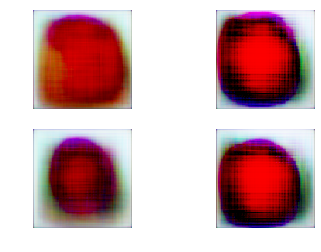

[Epoch 1/30] [Step 0/54] [D loss: 0.390492, acc:  52%] [G loss: 43.560822] time: 0:00:23.688407
[Epoch 1/30] [Step 1/54] [D loss: 0.373897, acc:  51%] [G loss: 40.160297] time: 0:00:23.850957
[Epoch 1/30] [Step 2/54] [D loss: 0.300875, acc:  55%] [G loss: 47.565594] time: 0:00:24.014354
[Epoch 1/30] [Step 3/54] [D loss: 0.327412, acc:  53%] [G loss: 53.648823] time: 0:00:24.175680
[Epoch 1/30] [Step 4/54] [D loss: 0.323514, acc:  51%] [G loss: 38.332870] time: 0:00:24.336552
[Epoch 1/30] [Step 5/54] [D loss: 0.349418, acc:  52%] [G loss: 47.163891] time: 0:00:24.497852
[Epoch 1/30] [Step 6/54] [D loss: 0.389569, acc:  53%] [G loss: 41.320312] time: 0:00:24.657925
[Epoch 1/30] [Step 7/54] [D loss: 0.343525, acc:  53%] [G loss: 42.588470] time: 0:00:24.820586
[Epoch 1/30] [Step 8/54] [D loss: 0.315606, acc:  56%] [G loss: 46.908119] time: 0:00:24.992371
[Epoch 1/30] [Step 9/54] [D loss: 0.344269, acc:  48%] [G loss: 39.658535] time: 0:00:25.167372
[Epoch 1/30] [Step 10/54] [D loss: 0.375

W0821 13:20:33.983685 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:33.985861 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:33.989821 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


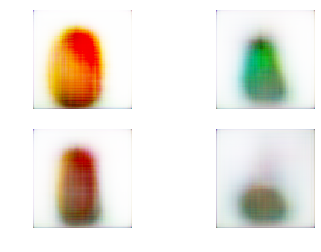

[Epoch 2/30] [Step 0/54] [D loss: 0.309202, acc:  61%] [G loss: 41.837315] time: 0:00:32.843893
[Epoch 2/30] [Step 1/54] [D loss: 0.278524, acc:  58%] [G loss: 42.589096] time: 0:00:33.011162
[Epoch 2/30] [Step 2/54] [D loss: 0.231466, acc:  63%] [G loss: 45.670605] time: 0:00:33.179551
[Epoch 2/30] [Step 3/54] [D loss: 0.303913, acc:  57%] [G loss: 37.053116] time: 0:00:33.342865
[Epoch 2/30] [Step 4/54] [D loss: 0.258439, acc:  63%] [G loss: 48.276657] time: 0:00:33.510474
[Epoch 2/30] [Step 5/54] [D loss: 0.296832, acc:  61%] [G loss: 38.334942] time: 0:00:33.674653
[Epoch 2/30] [Step 6/54] [D loss: 0.297178, acc:  56%] [G loss: 44.189629] time: 0:00:33.839730
[Epoch 2/30] [Step 7/54] [D loss: 0.287179, acc:  59%] [G loss: 46.326836] time: 0:00:34.003197
[Epoch 2/30] [Step 8/54] [D loss: 0.297390, acc:  56%] [G loss: 42.101791] time: 0:00:34.169714
[Epoch 2/30] [Step 9/54] [D loss: 0.430522, acc:  47%] [G loss: 43.952328] time: 0:00:34.334701
[Epoch 2/30] [Step 10/54] [D loss: 0.274

W0821 13:20:43.284240 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:43.286390 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:43.291621 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:43.294754 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


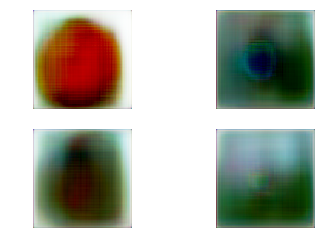

[Epoch 3/30] [Step 0/54] [D loss: 0.197716, acc:  72%] [G loss: 38.041695] time: 0:00:42.135645
[Epoch 3/30] [Step 1/54] [D loss: 0.172344, acc:  76%] [G loss: 36.821045] time: 0:00:42.302658
[Epoch 3/30] [Step 2/54] [D loss: 0.159656, acc:  75%] [G loss: 41.341553] time: 0:00:42.472745
[Epoch 3/30] [Step 3/54] [D loss: 0.245057, acc:  61%] [G loss: 40.143856] time: 0:00:42.637912
[Epoch 3/30] [Step 4/54] [D loss: 0.152837, acc:  78%] [G loss: 36.905609] time: 0:00:42.803024
[Epoch 3/30] [Step 5/54] [D loss: 0.224047, acc:  65%] [G loss: 38.492943] time: 0:00:42.964724
[Epoch 3/30] [Step 6/54] [D loss: 0.177028, acc:  74%] [G loss: 40.814095] time: 0:00:43.125528
[Epoch 3/30] [Step 7/54] [D loss: 0.161594, acc:  77%] [G loss: 35.569103] time: 0:00:43.287362
[Epoch 3/30] [Step 8/54] [D loss: 0.137750, acc:  81%] [G loss: 49.263729] time: 0:00:43.456233
[Epoch 3/30] [Step 9/54] [D loss: 0.237707, acc:  61%] [G loss: 37.102100] time: 0:00:43.618423
[Epoch 3/30] [Step 10/54] [D loss: 0.214

W0821 13:20:52.456004 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:52.458294 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:52.462802 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:20:52.468870 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


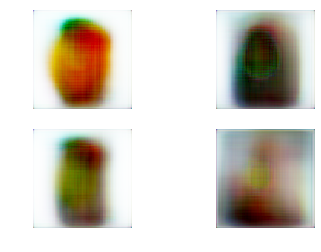

[Epoch 4/30] [Step 0/54] [D loss: 0.129874, acc:  83%] [G loss: 38.478527] time: 0:00:51.304609
[Epoch 4/30] [Step 1/54] [D loss: 0.158745, acc:  79%] [G loss: 41.560390] time: 0:00:51.466052
[Epoch 4/30] [Step 2/54] [D loss: 0.196902, acc:  73%] [G loss: 36.332233] time: 0:00:51.639386
[Epoch 4/30] [Step 3/54] [D loss: 0.343172, acc:  55%] [G loss: 39.981220] time: 0:00:51.799717
[Epoch 4/30] [Step 4/54] [D loss: 0.247441, acc:  63%] [G loss: 43.298225] time: 0:00:51.960702
[Epoch 4/30] [Step 5/54] [D loss: 0.250691, acc:  63%] [G loss: 41.612431] time: 0:00:52.122680
[Epoch 4/30] [Step 6/54] [D loss: 0.246412, acc:  61%] [G loss: 36.224571] time: 0:00:52.286337
[Epoch 4/30] [Step 7/54] [D loss: 0.198537, acc:  76%] [G loss: 37.750450] time: 0:00:52.447419
[Epoch 4/30] [Step 8/54] [D loss: 0.118101, acc:  86%] [G loss: 45.460121] time: 0:00:52.619200
[Epoch 4/30] [Step 9/54] [D loss: 0.131277, acc:  83%] [G loss: 36.583927] time: 0:00:52.782694
[Epoch 4/30] [Step 10/54] [D loss: 0.087

W0821 13:21:01.618610 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:01.620710 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:01.623813 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


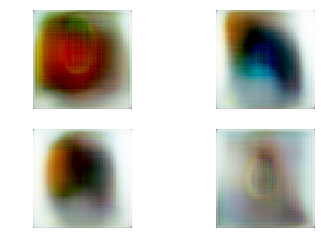

[Epoch 5/30] [Step 0/54] [D loss: 0.082431, acc:  92%] [G loss: 36.055283] time: 0:01:00.464848
[Epoch 5/30] [Step 1/54] [D loss: 0.079836, acc:  91%] [G loss: 39.043282] time: 0:01:00.628577
[Epoch 5/30] [Step 2/54] [D loss: 0.061805, acc:  95%] [G loss: 33.621021] time: 0:01:00.796236
[Epoch 5/30] [Step 3/54] [D loss: 0.077710, acc:  91%] [G loss: 36.134682] time: 0:01:00.958444
[Epoch 5/30] [Step 4/54] [D loss: 0.128626, acc:  83%] [G loss: 36.312420] time: 0:01:01.120220
[Epoch 5/30] [Step 5/54] [D loss: 0.096328, acc:  88%] [G loss: 35.924831] time: 0:01:01.283260
[Epoch 5/30] [Step 6/54] [D loss: 0.383873, acc:  61%] [G loss: 42.566246] time: 0:01:01.447349
[Epoch 5/30] [Step 7/54] [D loss: 0.179756, acc:  76%] [G loss: 36.879993] time: 0:01:01.610712
[Epoch 5/30] [Step 8/54] [D loss: 0.155013, acc:  82%] [G loss: 37.798241] time: 0:01:01.774308
[Epoch 5/30] [Step 9/54] [D loss: 0.103571, acc:  88%] [G loss: 38.283421] time: 0:01:01.936175
[Epoch 5/30] [Step 10/54] [D loss: 0.245

W0821 13:21:10.792228 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:10.794364 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:10.797551 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


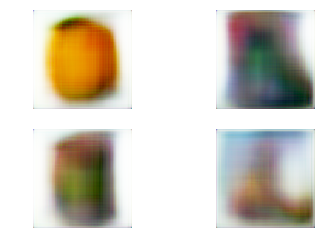

[Epoch 6/30] [Step 0/54] [D loss: 0.085320, acc:  91%] [G loss: 35.467960] time: 0:01:09.643130
[Epoch 6/30] [Step 1/54] [D loss: 0.085719, acc:  91%] [G loss: 38.238056] time: 0:01:09.806588
[Epoch 6/30] [Step 2/54] [D loss: 0.045322, acc:  98%] [G loss: 40.492538] time: 0:01:09.970488
[Epoch 6/30] [Step 3/54] [D loss: 0.058351, acc:  96%] [G loss: 44.430161] time: 0:01:10.133652
[Epoch 6/30] [Step 4/54] [D loss: 0.058417, acc:  95%] [G loss: 37.830784] time: 0:01:10.296654
[Epoch 6/30] [Step 5/54] [D loss: 0.047403, acc:  98%] [G loss: 33.235035] time: 0:01:10.460833
[Epoch 6/30] [Step 6/54] [D loss: 0.068605, acc:  95%] [G loss: 36.064434] time: 0:01:10.627278
[Epoch 6/30] [Step 7/54] [D loss: 0.117345, acc:  84%] [G loss: 42.092407] time: 0:01:10.790677
[Epoch 6/30] [Step 8/54] [D loss: 0.112381, acc:  87%] [G loss: 42.107719] time: 0:01:10.957641
[Epoch 6/30] [Step 9/54] [D loss: 0.194974, acc:  74%] [G loss: 39.084705] time: 0:01:11.121643
[Epoch 6/30] [Step 10/54] [D loss: 0.121

W0821 13:21:19.980686 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:19.982869 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:19.986221 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:19.990038 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


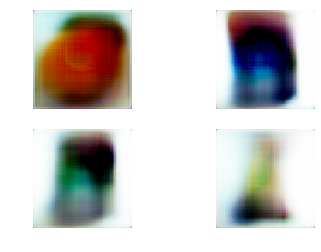

[Epoch 7/30] [Step 0/54] [D loss: 0.075930, acc:  95%] [G loss: 36.743786] time: 0:01:18.820981
[Epoch 7/30] [Step 1/54] [D loss: 0.105465, acc:  87%] [G loss: 40.411110] time: 0:01:18.986378
[Epoch 7/30] [Step 2/54] [D loss: 0.075602, acc:  93%] [G loss: 31.900627] time: 0:01:19.152485
[Epoch 7/30] [Step 3/54] [D loss: 0.127600, acc:  84%] [G loss: 43.873436] time: 0:01:19.316792
[Epoch 7/30] [Step 4/54] [D loss: 0.125569, acc:  86%] [G loss: 40.816589] time: 0:01:19.481942
[Epoch 7/30] [Step 5/54] [D loss: 0.122189, acc:  87%] [G loss: 36.528820] time: 0:01:19.646146
[Epoch 7/30] [Step 6/54] [D loss: 0.113422, acc:  85%] [G loss: 36.531521] time: 0:01:19.813787
[Epoch 7/30] [Step 7/54] [D loss: 0.081106, acc:  92%] [G loss: 35.754307] time: 0:01:19.975561
[Epoch 7/30] [Step 8/54] [D loss: 0.095800, acc:  89%] [G loss: 37.808643] time: 0:01:20.136044
[Epoch 7/30] [Step 9/54] [D loss: 0.067599, acc:  95%] [G loss: 34.357090] time: 0:01:20.308276
[Epoch 7/30] [Step 10/54] [D loss: 0.077

W0821 13:21:29.134127 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:29.136300 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:29.140740 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


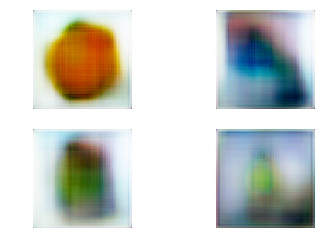

[Epoch 8/30] [Step 0/54] [D loss: 0.051400, acc:  97%] [G loss: 34.607700] time: 0:01:27.982219
[Epoch 8/30] [Step 1/54] [D loss: 0.050646, acc:  96%] [G loss: 39.458927] time: 0:01:28.152693
[Epoch 8/30] [Step 2/54] [D loss: 0.049888, acc:  97%] [G loss: 33.200665] time: 0:01:28.324528
[Epoch 8/30] [Step 3/54] [D loss: 0.057216, acc:  96%] [G loss: 34.732811] time: 0:01:28.492955
[Epoch 8/30] [Step 4/54] [D loss: 0.047266, acc:  98%] [G loss: 34.969910] time: 0:01:28.658695
[Epoch 8/30] [Step 5/54] [D loss: 0.063535, acc:  95%] [G loss: 36.073338] time: 0:01:28.820942
[Epoch 8/30] [Step 6/54] [D loss: 0.038027, acc:  98%] [G loss: 36.490124] time: 0:01:28.988347
[Epoch 8/30] [Step 7/54] [D loss: 0.073212, acc:  93%] [G loss: 36.909763] time: 0:01:29.151093
[Epoch 8/30] [Step 8/54] [D loss: 0.097352, acc:  89%] [G loss: 34.221180] time: 0:01:29.317864
[Epoch 8/30] [Step 9/54] [D loss: 0.049552, acc:  97%] [G loss: 33.608753] time: 0:01:29.483332
[Epoch 8/30] [Step 10/54] [D loss: 0.053

W0821 13:21:38.307093 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:38.311930 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:38.314038 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:38.317589 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


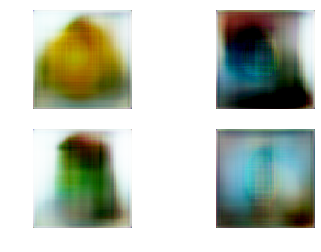

[Epoch 9/30] [Step 0/54] [D loss: 0.072485, acc:  93%] [G loss: 40.099293] time: 0:01:37.167956
[Epoch 9/30] [Step 1/54] [D loss: 0.069476, acc:  93%] [G loss: 31.787365] time: 0:01:37.333352
[Epoch 9/30] [Step 2/54] [D loss: 0.049163, acc:  97%] [G loss: 35.549263] time: 0:01:37.498412
[Epoch 9/30] [Step 3/54] [D loss: 0.034466, acc:  99%] [G loss: 33.352238] time: 0:01:37.662789
[Epoch 9/30] [Step 4/54] [D loss: 0.034626, acc:  99%] [G loss: 36.766281] time: 0:01:37.827851
[Epoch 9/30] [Step 5/54] [D loss: 0.061345, acc:  96%] [G loss: 35.433250] time: 0:01:37.991866
[Epoch 9/30] [Step 6/54] [D loss: 0.046216, acc:  98%] [G loss: 35.941292] time: 0:01:38.154757
[Epoch 9/30] [Step 7/54] [D loss: 0.028760, acc:  99%] [G loss: 32.573605] time: 0:01:38.318898
[Epoch 9/30] [Step 8/54] [D loss: 0.051707, acc:  98%] [G loss: 36.545979] time: 0:01:38.483261
[Epoch 9/30] [Step 9/54] [D loss: 0.055592, acc:  98%] [G loss: 32.814831] time: 0:01:38.647239
[Epoch 9/30] [Step 10/54] [D loss: 0.034

W0821 13:21:47.492594 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:47.494665 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:47.498458 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:47.501319 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


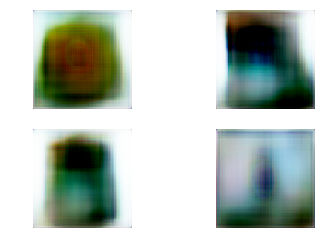

[Epoch 10/30] [Step 0/54] [D loss: 0.034491, acc:  99%] [G loss: 32.055153] time: 0:01:46.344313
[Epoch 10/30] [Step 1/54] [D loss: 0.080578, acc:  94%] [G loss: 31.298521] time: 0:01:46.509047
[Epoch 10/30] [Step 2/54] [D loss: 0.116665, acc:  84%] [G loss: 34.723083] time: 0:01:46.672935
[Epoch 10/30] [Step 3/54] [D loss: 0.075809, acc:  92%] [G loss: 40.109116] time: 0:01:46.840102
[Epoch 10/30] [Step 4/54] [D loss: 0.111060, acc:  86%] [G loss: 34.849197] time: 0:01:47.006015
[Epoch 10/30] [Step 5/54] [D loss: 0.032683, acc:  99%] [G loss: 38.376122] time: 0:01:47.168567
[Epoch 10/30] [Step 6/54] [D loss: 0.030755, acc:  99%] [G loss: 34.432888] time: 0:01:47.332885
[Epoch 10/30] [Step 7/54] [D loss: 0.032156, acc:  98%] [G loss: 41.761028] time: 0:01:47.495761
[Epoch 10/30] [Step 8/54] [D loss: 0.039176, acc:  98%] [G loss: 34.055862] time: 0:01:47.658368
[Epoch 10/30] [Step 9/54] [D loss: 0.036842, acc:  99%] [G loss: 36.498657] time: 0:01:47.821707
[Epoch 10/30] [Step 10/54] [D 

W0821 13:21:56.679883 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:56.682068 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:56.685249 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:21:56.688924 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


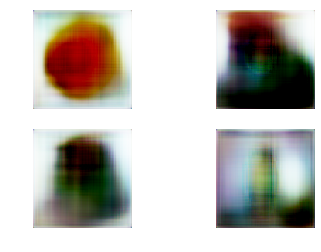

[Epoch 11/30] [Step 0/54] [D loss: 0.034966, acc:  99%] [G loss: 34.948120] time: 0:01:55.528614
[Epoch 11/30] [Step 1/54] [D loss: 0.033734, acc:  99%] [G loss: 32.772942] time: 0:01:55.693746
[Epoch 11/30] [Step 2/54] [D loss: 0.029235, acc:  99%] [G loss: 37.206657] time: 0:01:55.860285
[Epoch 11/30] [Step 3/54] [D loss: 0.064409, acc:  96%] [G loss: 32.974796] time: 0:01:56.024657
[Epoch 11/30] [Step 4/54] [D loss: 0.035002, acc:  99%] [G loss: 32.623871] time: 0:01:56.188019
[Epoch 11/30] [Step 5/54] [D loss: 0.063558, acc:  96%] [G loss: 35.471783] time: 0:01:56.357963
[Epoch 11/30] [Step 6/54] [D loss: 0.050606, acc:  97%] [G loss: 35.231907] time: 0:01:56.525110
[Epoch 11/30] [Step 7/54] [D loss: 0.051996, acc:  98%] [G loss: 33.183254] time: 0:01:56.690382
[Epoch 11/30] [Step 8/54] [D loss: 0.114074, acc:  87%] [G loss: 46.291325] time: 0:01:56.857581
[Epoch 11/30] [Step 9/54] [D loss: 0.045127, acc:  97%] [G loss: 34.940399] time: 0:01:57.019613
[Epoch 11/30] [Step 10/54] [D 

W0821 13:22:05.893244 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:05.895318 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:05.897266 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:05.900183 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


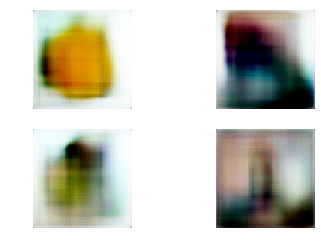

[Epoch 12/30] [Step 0/54] [D loss: 0.029940, acc:  99%] [G loss: 33.103821] time: 0:02:04.735451
[Epoch 12/30] [Step 1/54] [D loss: 0.026946, acc:  99%] [G loss: 29.826513] time: 0:02:04.896010
[Epoch 12/30] [Step 2/54] [D loss: 0.026998, acc:  99%] [G loss: 31.297779] time: 0:02:05.059785
[Epoch 12/30] [Step 3/54] [D loss: 0.032293, acc:  99%] [G loss: 32.182838] time: 0:02:05.221292
[Epoch 12/30] [Step 4/54] [D loss: 0.020957, acc:  99%] [G loss: 37.446423] time: 0:02:05.383553
[Epoch 12/30] [Step 5/54] [D loss: 0.025893, acc:  99%] [G loss: 34.727177] time: 0:02:05.545424
[Epoch 12/30] [Step 6/54] [D loss: 0.023335, acc:  99%] [G loss: 34.832703] time: 0:02:05.709906
[Epoch 12/30] [Step 7/54] [D loss: 0.056821, acc:  96%] [G loss: 34.626698] time: 0:02:05.872655
[Epoch 12/30] [Step 8/54] [D loss: 0.039087, acc:  97%] [G loss: 35.285336] time: 0:02:06.036428
[Epoch 12/30] [Step 9/54] [D loss: 0.032907, acc:  99%] [G loss: 31.916006] time: 0:02:06.198323
[Epoch 12/30] [Step 10/54] [D 

W0821 13:22:15.086292 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:15.088355 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:15.091605 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:15.094181 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


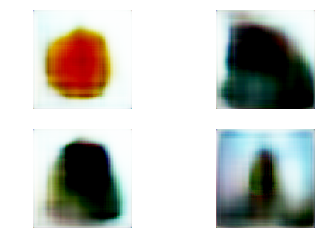

[Epoch 13/30] [Step 0/54] [D loss: 0.045468, acc:  98%] [G loss: 34.356678] time: 0:02:13.922348
[Epoch 13/30] [Step 1/54] [D loss: 0.039558, acc:  98%] [G loss: 34.689606] time: 0:02:14.086986
[Epoch 13/30] [Step 2/54] [D loss: 0.017977, acc: 100%] [G loss: 33.574066] time: 0:02:14.255553
[Epoch 13/30] [Step 3/54] [D loss: 0.022484, acc:  99%] [G loss: 36.385277] time: 0:02:14.418927
[Epoch 13/30] [Step 4/54] [D loss: 0.029975, acc:  98%] [G loss: 39.813755] time: 0:02:14.588507
[Epoch 13/30] [Step 5/54] [D loss: 0.049913, acc:  97%] [G loss: 36.947334] time: 0:02:14.752382
[Epoch 13/30] [Step 6/54] [D loss: 0.022024, acc:  99%] [G loss: 31.300797] time: 0:02:14.918153
[Epoch 13/30] [Step 7/54] [D loss: 0.023059, acc:  99%] [G loss: 31.264435] time: 0:02:15.082281
[Epoch 13/30] [Step 8/54] [D loss: 0.028972, acc:  99%] [G loss: 34.445107] time: 0:02:15.249743
[Epoch 13/30] [Step 9/54] [D loss: 0.027013, acc:  99%] [G loss: 39.700085] time: 0:02:15.414937
[Epoch 13/30] [Step 10/54] [D 

W0821 13:22:24.272381 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:24.274547 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:24.277161 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:24.280095 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


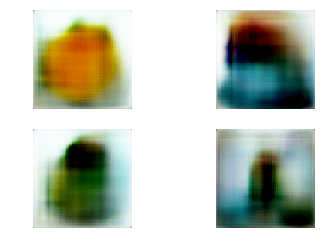

[Epoch 14/30] [Step 0/54] [D loss: 0.048310, acc:  97%] [G loss: 31.468765] time: 0:02:23.125980
[Epoch 14/30] [Step 1/54] [D loss: 0.051784, acc:  96%] [G loss: 29.489826] time: 0:02:23.291064
[Epoch 14/30] [Step 2/54] [D loss: 0.059278, acc:  94%] [G loss: 33.817501] time: 0:02:23.459948
[Epoch 14/30] [Step 3/54] [D loss: 0.064425, acc:  95%] [G loss: 32.551899] time: 0:02:23.624869
[Epoch 14/30] [Step 4/54] [D loss: 0.042236, acc:  98%] [G loss: 32.482502] time: 0:02:23.794360
[Epoch 14/30] [Step 5/54] [D loss: 0.050503, acc:  95%] [G loss: 35.029854] time: 0:02:23.957695
[Epoch 14/30] [Step 6/54] [D loss: 0.145809, acc:  81%] [G loss: 31.850559] time: 0:02:24.120046
[Epoch 14/30] [Step 7/54] [D loss: 0.193495, acc:  76%] [G loss: 34.589947] time: 0:02:24.283904
[Epoch 14/30] [Step 8/54] [D loss: 0.040544, acc:  99%] [G loss: 29.466589] time: 0:02:24.447358
[Epoch 14/30] [Step 9/54] [D loss: 0.115731, acc:  84%] [G loss: 34.730198] time: 0:02:24.611060
[Epoch 14/30] [Step 10/54] [D 

W0821 13:22:33.496945 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:33.499183 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:33.503097 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:33.507672 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


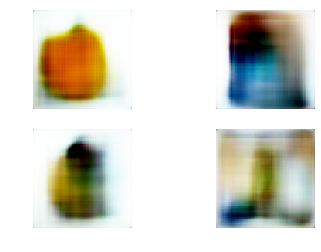

[Epoch 15/30] [Step 0/54] [D loss: 0.044168, acc:  97%] [G loss: 37.052685] time: 0:02:32.345378
[Epoch 15/30] [Step 1/54] [D loss: 0.021678, acc:  99%] [G loss: 33.315414] time: 0:02:32.512138
[Epoch 15/30] [Step 2/54] [D loss: 0.043547, acc:  97%] [G loss: 30.864647] time: 0:02:32.678919
[Epoch 15/30] [Step 3/54] [D loss: 0.028758, acc:  99%] [G loss: 35.411057] time: 0:02:32.847603
[Epoch 15/30] [Step 4/54] [D loss: 0.045420, acc:  98%] [G loss: 29.534035] time: 0:02:33.018249
[Epoch 15/30] [Step 5/54] [D loss: 0.026451, acc:  99%] [G loss: 31.546803] time: 0:02:33.184050
[Epoch 15/30] [Step 6/54] [D loss: 0.031114, acc:  99%] [G loss: 29.096848] time: 0:02:33.349192
[Epoch 15/30] [Step 7/54] [D loss: 0.023404, acc:  99%] [G loss: 28.205120] time: 0:02:33.513062
[Epoch 15/30] [Step 8/54] [D loss: 0.018053, acc:  99%] [G loss: 29.504570] time: 0:02:33.679536
[Epoch 15/30] [Step 9/54] [D loss: 0.041953, acc:  98%] [G loss: 31.761641] time: 0:02:33.850198
[Epoch 15/30] [Step 10/54] [D 

W0821 13:22:42.815060 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:42.817652 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:42.820786 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:42.823408 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


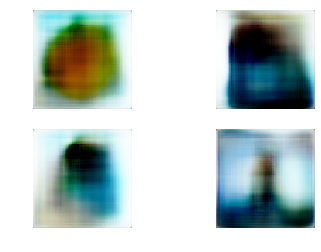

[Epoch 16/30] [Step 0/54] [D loss: 0.015550, acc: 100%] [G loss: 32.248306] time: 0:02:41.663261
[Epoch 16/30] [Step 1/54] [D loss: 0.016115, acc: 100%] [G loss: 28.381090] time: 0:02:41.827097
[Epoch 16/30] [Step 2/54] [D loss: 0.033992, acc:  99%] [G loss: 33.875008] time: 0:02:41.992188
[Epoch 16/30] [Step 3/54] [D loss: 0.023826, acc:  99%] [G loss: 30.659143] time: 0:02:42.159792
[Epoch 16/30] [Step 4/54] [D loss: 0.072695, acc:  94%] [G loss: 31.154711] time: 0:02:42.325913
[Epoch 16/30] [Step 5/54] [D loss: 0.071759, acc:  95%] [G loss: 34.800804] time: 0:02:42.488732
[Epoch 16/30] [Step 6/54] [D loss: 0.035977, acc:  98%] [G loss: 33.743526] time: 0:02:42.653866
[Epoch 16/30] [Step 7/54] [D loss: 0.032720, acc:  99%] [G loss: 29.431768] time: 0:02:42.818001
[Epoch 16/30] [Step 8/54] [D loss: 0.027086, acc:  99%] [G loss: 35.378700] time: 0:02:42.987112
[Epoch 16/30] [Step 9/54] [D loss: 0.036332, acc:  98%] [G loss: 30.619642] time: 0:02:43.151174
[Epoch 16/30] [Step 10/54] [D 

W0821 13:22:52.055348 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:52.057490 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:52.059427 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:22:52.062288 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


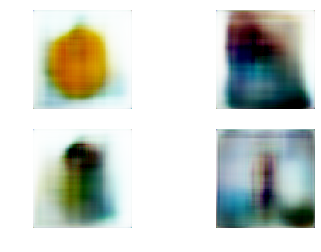

[Epoch 17/30] [Step 0/54] [D loss: 0.073672, acc:  91%] [G loss: 31.238585] time: 0:02:50.904685
[Epoch 17/30] [Step 1/54] [D loss: 0.031878, acc:  98%] [G loss: 34.500710] time: 0:02:51.066821
[Epoch 17/30] [Step 2/54] [D loss: 0.054477, acc:  96%] [G loss: 35.790798] time: 0:02:51.239007
[Epoch 17/30] [Step 3/54] [D loss: 0.031646, acc:  99%] [G loss: 29.061241] time: 0:02:51.408754
[Epoch 17/30] [Step 4/54] [D loss: 0.019728, acc:  99%] [G loss: 36.828377] time: 0:02:51.574581
[Epoch 17/30] [Step 5/54] [D loss: 0.044125, acc:  97%] [G loss: 32.558769] time: 0:02:51.738690
[Epoch 17/30] [Step 6/54] [D loss: 0.025570, acc:  99%] [G loss: 32.592922] time: 0:02:51.898957
[Epoch 17/30] [Step 7/54] [D loss: 0.058726, acc:  95%] [G loss: 32.258381] time: 0:02:52.064487
[Epoch 17/30] [Step 8/54] [D loss: 0.037003, acc:  98%] [G loss: 25.160007] time: 0:02:52.228698
[Epoch 17/30] [Step 9/54] [D loss: 0.018022, acc: 100%] [G loss: 26.727646] time: 0:02:52.395346
[Epoch 17/30] [Step 10/54] [D 

W0821 13:23:01.316215 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:01.318302 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:01.321168 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:01.325022 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


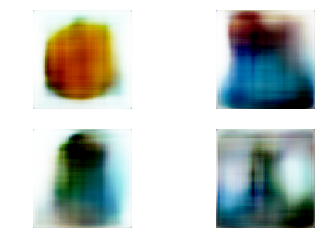

[Epoch 18/30] [Step 0/54] [D loss: 0.064536, acc:  94%] [G loss: 32.130959] time: 0:03:00.167021
[Epoch 18/30] [Step 1/54] [D loss: 0.055138, acc:  96%] [G loss: 30.906914] time: 0:03:00.331722
[Epoch 18/30] [Step 2/54] [D loss: 0.049541, acc:  98%] [G loss: 31.371531] time: 0:03:00.496308
[Epoch 18/30] [Step 3/54] [D loss: 0.068690, acc:  93%] [G loss: 36.318264] time: 0:03:00.666276
[Epoch 18/30] [Step 4/54] [D loss: 0.075962, acc:  92%] [G loss: 34.237289] time: 0:03:00.833194
[Epoch 18/30] [Step 5/54] [D loss: 0.061344, acc:  94%] [G loss: 31.319489] time: 0:03:00.996976
[Epoch 18/30] [Step 6/54] [D loss: 0.036231, acc:  98%] [G loss: 30.918140] time: 0:03:01.166096
[Epoch 18/30] [Step 7/54] [D loss: 0.047407, acc:  96%] [G loss: 34.988277] time: 0:03:01.332106
[Epoch 18/30] [Step 8/54] [D loss: 0.045869, acc:  96%] [G loss: 29.037743] time: 0:03:01.497662
[Epoch 18/30] [Step 9/54] [D loss: 0.050159, acc:  97%] [G loss: 34.424255] time: 0:03:01.683878
[Epoch 18/30] [Step 10/54] [D 

W0821 13:23:10.618937 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:10.621344 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:10.624116 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:10.629023 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


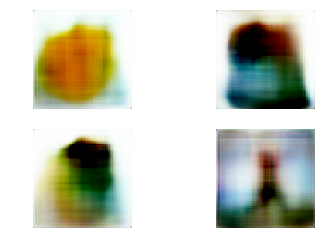

[Epoch 19/30] [Step 0/54] [D loss: 0.038919, acc:  97%] [G loss: 37.302532] time: 0:03:09.464806
[Epoch 19/30] [Step 1/54] [D loss: 0.052755, acc:  96%] [G loss: 32.147388] time: 0:03:09.628889
[Epoch 19/30] [Step 2/54] [D loss: 0.022825, acc:  99%] [G loss: 29.308931] time: 0:03:09.794352
[Epoch 19/30] [Step 3/54] [D loss: 0.031153, acc: 100%] [G loss: 32.125465] time: 0:03:09.961338
[Epoch 19/30] [Step 4/54] [D loss: 0.022529, acc: 100%] [G loss: 33.032196] time: 0:03:10.129011
[Epoch 19/30] [Step 5/54] [D loss: 0.011622, acc: 100%] [G loss: 38.793102] time: 0:03:10.293618
[Epoch 19/30] [Step 6/54] [D loss: 0.014633, acc: 100%] [G loss: 34.238613] time: 0:03:10.462669
[Epoch 19/30] [Step 7/54] [D loss: 0.018022, acc:  99%] [G loss: 33.507877] time: 0:03:10.625989
[Epoch 19/30] [Step 8/54] [D loss: 0.011897, acc: 100%] [G loss: 33.697380] time: 0:03:10.790088
[Epoch 19/30] [Step 9/54] [D loss: 0.019758, acc:  99%] [G loss: 33.486961] time: 0:03:10.954080
[Epoch 19/30] [Step 10/54] [D 

W0821 13:23:19.890840 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:19.893087 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:19.895442 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:19.897841 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


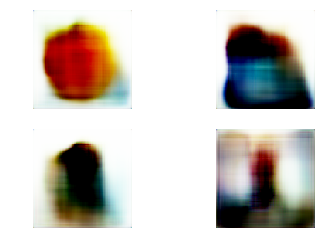

[Epoch 20/30] [Step 0/54] [D loss: 0.094960, acc:  91%] [G loss: 34.183086] time: 0:03:18.730362
[Epoch 20/30] [Step 1/54] [D loss: 0.069649, acc:  93%] [G loss: 28.508686] time: 0:03:18.896398
[Epoch 20/30] [Step 2/54] [D loss: 0.036284, acc:  99%] [G loss: 27.079844] time: 0:03:19.062539
[Epoch 20/30] [Step 3/54] [D loss: 0.023211, acc: 100%] [G loss: 31.549831] time: 0:03:19.229863
[Epoch 20/30] [Step 4/54] [D loss: 0.088816, acc:  91%] [G loss: 27.272379] time: 0:03:19.406822
[Epoch 20/30] [Step 5/54] [D loss: 0.085805, acc:  91%] [G loss: 27.534933] time: 0:03:19.572096
[Epoch 20/30] [Step 6/54] [D loss: 0.038384, acc:  98%] [G loss: 36.254749] time: 0:03:19.739061
[Epoch 20/30] [Step 7/54] [D loss: 0.055803, acc:  95%] [G loss: 31.446695] time: 0:03:19.907210
[Epoch 20/30] [Step 8/54] [D loss: 0.145712, acc:  82%] [G loss: 34.561806] time: 0:03:20.079014
[Epoch 20/30] [Step 9/54] [D loss: 0.048051, acc:  97%] [G loss: 33.659248] time: 0:03:20.245903
[Epoch 20/30] [Step 10/54] [D 

W0821 13:23:29.204479 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:29.206468 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:29.211694 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:29.214614 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


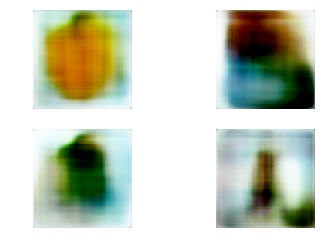

[Epoch 21/30] [Step 0/54] [D loss: 0.013156, acc:  99%] [G loss: 32.658554] time: 0:03:28.058264
[Epoch 21/30] [Step 1/54] [D loss: 0.009569, acc: 100%] [G loss: 28.226271] time: 0:03:28.226232
[Epoch 21/30] [Step 2/54] [D loss: 0.020415, acc: 100%] [G loss: 26.416187] time: 0:03:28.390945
[Epoch 21/30] [Step 3/54] [D loss: 0.013524, acc: 100%] [G loss: 29.609690] time: 0:03:28.555232
[Epoch 21/30] [Step 4/54] [D loss: 0.029192, acc:  99%] [G loss: 32.475677] time: 0:03:28.720375
[Epoch 21/30] [Step 5/54] [D loss: 0.014603, acc: 100%] [G loss: 29.145061] time: 0:03:28.882586
[Epoch 21/30] [Step 6/54] [D loss: 0.022622, acc:  99%] [G loss: 31.147814] time: 0:03:29.045282
[Epoch 21/30] [Step 7/54] [D loss: 0.038681, acc:  98%] [G loss: 35.429832] time: 0:03:29.209556
[Epoch 21/30] [Step 8/54] [D loss: 0.016455, acc: 100%] [G loss: 31.771790] time: 0:03:29.379805
[Epoch 21/30] [Step 9/54] [D loss: 0.014478, acc: 100%] [G loss: 34.996857] time: 0:03:29.547349
[Epoch 21/30] [Step 10/54] [D 

W0821 13:23:38.452714 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:38.454734 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:38.457857 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:38.461761 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


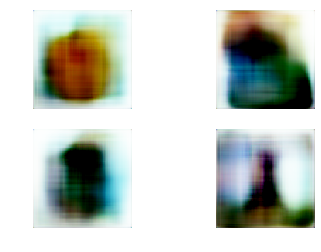

[Epoch 22/30] [Step 0/54] [D loss: 0.024426, acc: 100%] [G loss: 31.058121] time: 0:03:37.302021
[Epoch 22/30] [Step 1/54] [D loss: 0.026089, acc:  98%] [G loss: 30.196472] time: 0:03:37.469206
[Epoch 22/30] [Step 2/54] [D loss: 0.017046, acc: 100%] [G loss: 29.489561] time: 0:03:37.635037
[Epoch 22/30] [Step 3/54] [D loss: 0.058260, acc:  96%] [G loss: 30.148441] time: 0:03:37.799367
[Epoch 22/30] [Step 4/54] [D loss: 0.035977, acc:  97%] [G loss: 30.424702] time: 0:03:37.964004
[Epoch 22/30] [Step 5/54] [D loss: 0.026207, acc:  99%] [G loss: 38.506882] time: 0:03:38.129688
[Epoch 22/30] [Step 6/54] [D loss: 0.031151, acc:  98%] [G loss: 32.317387] time: 0:03:38.294709
[Epoch 22/30] [Step 7/54] [D loss: 0.030223, acc:  98%] [G loss: 28.892611] time: 0:03:38.462989
[Epoch 22/30] [Step 8/54] [D loss: 0.015955, acc:  99%] [G loss: 33.190968] time: 0:03:38.632223
[Epoch 22/30] [Step 9/54] [D loss: 0.014019, acc: 100%] [G loss: 32.709141] time: 0:03:38.797310
[Epoch 22/30] [Step 10/54] [D 

W0821 13:23:47.739380 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:47.741485 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:47.744510 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:47.748322 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


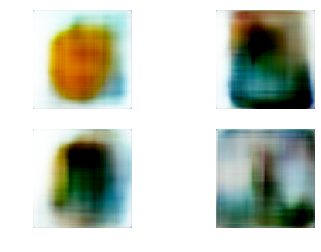

[Epoch 23/30] [Step 0/54] [D loss: 0.031882, acc:  99%] [G loss: 32.682022] time: 0:03:46.586749
[Epoch 23/30] [Step 1/54] [D loss: 0.041824, acc:  98%] [G loss: 34.662788] time: 0:03:46.754054
[Epoch 23/30] [Step 2/54] [D loss: 0.025812, acc:  98%] [G loss: 34.801796] time: 0:03:46.921866
[Epoch 23/30] [Step 3/54] [D loss: 0.029318, acc:  99%] [G loss: 35.146492] time: 0:03:47.086106
[Epoch 23/30] [Step 4/54] [D loss: 0.071065, acc:  94%] [G loss: 29.662334] time: 0:03:47.253077
[Epoch 23/30] [Step 5/54] [D loss: 0.047357, acc:  96%] [G loss: 29.526819] time: 0:03:47.420260
[Epoch 23/30] [Step 6/54] [D loss: 0.049113, acc:  97%] [G loss: 28.006313] time: 0:03:47.586357
[Epoch 23/30] [Step 7/54] [D loss: 0.027316, acc:  99%] [G loss: 29.916985] time: 0:03:47.757248
[Epoch 23/30] [Step 8/54] [D loss: 0.027886, acc:  99%] [G loss: 31.246172] time: 0:03:47.923015
[Epoch 23/30] [Step 9/54] [D loss: 0.014658, acc: 100%] [G loss: 31.065025] time: 0:03:48.086214
[Epoch 23/30] [Step 10/54] [D 

W0821 13:23:57.014916 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:57.019072 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:57.023288 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:23:57.026702 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


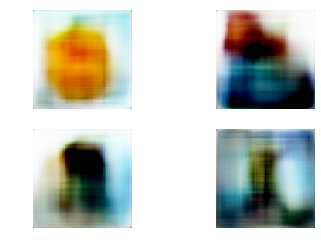

[Epoch 24/30] [Step 0/54] [D loss: 0.015816, acc:  99%] [G loss: 30.020144] time: 0:03:55.878639
[Epoch 24/30] [Step 1/54] [D loss: 0.022301, acc:  99%] [G loss: 32.007587] time: 0:03:56.044944
[Epoch 24/30] [Step 2/54] [D loss: 0.015993, acc: 100%] [G loss: 29.605347] time: 0:03:56.213180
[Epoch 24/30] [Step 3/54] [D loss: 0.009616, acc: 100%] [G loss: 31.635649] time: 0:03:56.378082
[Epoch 24/30] [Step 4/54] [D loss: 0.011532, acc: 100%] [G loss: 31.723978] time: 0:03:56.543649
[Epoch 24/30] [Step 5/54] [D loss: 0.013804, acc: 100%] [G loss: 30.992418] time: 0:03:56.708599
[Epoch 24/30] [Step 6/54] [D loss: 0.014287, acc: 100%] [G loss: 29.925716] time: 0:03:56.878542
[Epoch 24/30] [Step 7/54] [D loss: 0.014620, acc: 100%] [G loss: 27.989826] time: 0:03:57.053368
[Epoch 24/30] [Step 8/54] [D loss: 0.040443, acc: 100%] [G loss: 28.310606] time: 0:03:57.223957
[Epoch 24/30] [Step 9/54] [D loss: 0.023406, acc:  99%] [G loss: 30.797770] time: 0:03:57.387512
[Epoch 24/30] [Step 10/54] [D 

W0821 13:24:06.350152 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:06.353948 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:06.356168 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:06.360051 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


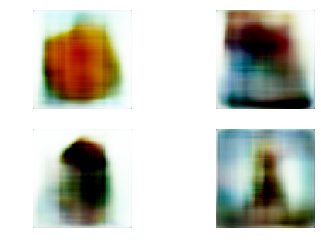

[Epoch 25/30] [Step 0/54] [D loss: 0.033582, acc:  99%] [G loss: 33.835407] time: 0:04:05.208466
[Epoch 25/30] [Step 1/54] [D loss: 0.045840, acc:  98%] [G loss: 28.472385] time: 0:04:05.374779
[Epoch 25/30] [Step 2/54] [D loss: 0.022035, acc:  99%] [G loss: 31.188272] time: 0:04:05.540794
[Epoch 25/30] [Step 3/54] [D loss: 0.019138, acc: 100%] [G loss: 28.770861] time: 0:04:05.706026
[Epoch 25/30] [Step 4/54] [D loss: 0.014143, acc: 100%] [G loss: 32.935089] time: 0:04:05.871437
[Epoch 25/30] [Step 5/54] [D loss: 0.039872, acc:  97%] [G loss: 27.417284] time: 0:04:06.034971
[Epoch 25/30] [Step 6/54] [D loss: 0.067662, acc:  94%] [G loss: 28.047878] time: 0:04:06.204737
[Epoch 25/30] [Step 7/54] [D loss: 0.054388, acc:  94%] [G loss: 29.258709] time: 0:04:06.369816
[Epoch 25/30] [Step 8/54] [D loss: 0.040493, acc:  98%] [G loss: 33.332554] time: 0:04:06.538604
[Epoch 25/30] [Step 9/54] [D loss: 0.049308, acc:  94%] [G loss: 31.610384] time: 0:04:06.704716
[Epoch 25/30] [Step 10/54] [D 

W0821 13:24:15.625514 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:15.627487 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:15.631023 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:15.637482 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


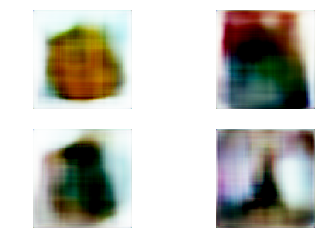

[Epoch 26/30] [Step 0/54] [D loss: 0.028928, acc:  99%] [G loss: 24.292881] time: 0:04:14.481601
[Epoch 26/30] [Step 1/54] [D loss: 0.017482, acc: 100%] [G loss: 29.169243] time: 0:04:14.653086
[Epoch 26/30] [Step 2/54] [D loss: 0.012439, acc: 100%] [G loss: 39.314274] time: 0:04:14.822418
[Epoch 26/30] [Step 3/54] [D loss: 0.035667, acc:  98%] [G loss: 29.073362] time: 0:04:14.986395
[Epoch 26/30] [Step 4/54] [D loss: 0.023753, acc:  99%] [G loss: 31.251770] time: 0:04:15.153335
[Epoch 26/30] [Step 5/54] [D loss: 0.024254, acc:  99%] [G loss: 32.272526] time: 0:04:15.318771
[Epoch 26/30] [Step 6/54] [D loss: 0.013035, acc: 100%] [G loss: 29.055964] time: 0:04:15.486681
[Epoch 26/30] [Step 7/54] [D loss: 0.015583, acc: 100%] [G loss: 32.856873] time: 0:04:15.652723
[Epoch 26/30] [Step 8/54] [D loss: 0.032381, acc:  98%] [G loss: 32.510262] time: 0:04:15.820818
[Epoch 26/30] [Step 9/54] [D loss: 0.019125, acc:  99%] [G loss: 29.244408] time: 0:04:15.986691
[Epoch 26/30] [Step 10/54] [D 

W0821 13:24:24.895277 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:24.898262 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:24.901383 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:24.903930 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


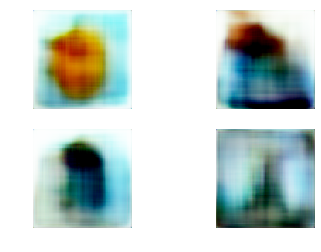

[Epoch 27/30] [Step 0/54] [D loss: 0.057955, acc:  95%] [G loss: 37.080853] time: 0:04:23.754424
[Epoch 27/30] [Step 1/54] [D loss: 0.041763, acc:  97%] [G loss: 30.594543] time: 0:04:23.920605
[Epoch 27/30] [Step 2/54] [D loss: 0.050898, acc:  97%] [G loss: 30.354826] time: 0:04:24.088136
[Epoch 27/30] [Step 3/54] [D loss: 0.027262, acc:  99%] [G loss: 30.828569] time: 0:04:24.255011
[Epoch 27/30] [Step 4/54] [D loss: 0.026303, acc:  99%] [G loss: 31.155598] time: 0:04:24.421921
[Epoch 27/30] [Step 5/54] [D loss: 0.017420, acc:  99%] [G loss: 35.974136] time: 0:04:24.589678
[Epoch 27/30] [Step 6/54] [D loss: 0.012527, acc: 100%] [G loss: 29.798092] time: 0:04:24.757091
[Epoch 27/30] [Step 7/54] [D loss: 0.055775, acc:  95%] [G loss: 34.633518] time: 0:04:24.922385
[Epoch 27/30] [Step 8/54] [D loss: 0.041871, acc:  97%] [G loss: 35.878078] time: 0:04:25.098772
[Epoch 27/30] [Step 9/54] [D loss: 0.044870, acc:  98%] [G loss: 26.380217] time: 0:04:25.264670
[Epoch 27/30] [Step 10/54] [D 

W0821 13:24:34.173182 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:34.175308 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:34.178480 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:34.181097 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


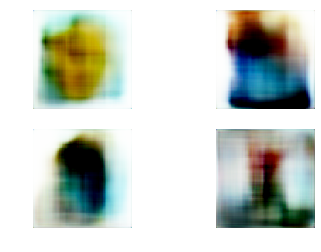

[Epoch 28/30] [Step 0/54] [D loss: 0.020184, acc:  99%] [G loss: 27.875250] time: 0:04:33.029041
[Epoch 28/30] [Step 1/54] [D loss: 0.020103, acc:  99%] [G loss: 25.787655] time: 0:04:33.196669
[Epoch 28/30] [Step 2/54] [D loss: 0.014192, acc: 100%] [G loss: 28.377245] time: 0:04:33.361674
[Epoch 28/30] [Step 3/54] [D loss: 0.047271, acc:  98%] [G loss: 27.980904] time: 0:04:33.523147
[Epoch 28/30] [Step 4/54] [D loss: 0.016855, acc:  99%] [G loss: 32.198143] time: 0:04:33.686680
[Epoch 28/30] [Step 5/54] [D loss: 0.024284, acc:  99%] [G loss: 32.490768] time: 0:04:33.856445
[Epoch 28/30] [Step 6/54] [D loss: 0.014547, acc:  99%] [G loss: 35.878647] time: 0:04:34.027009
[Epoch 28/30] [Step 7/54] [D loss: 0.029664, acc:  99%] [G loss: 32.250954] time: 0:04:34.191444
[Epoch 28/30] [Step 8/54] [D loss: 0.024514, acc:  99%] [G loss: 29.936825] time: 0:04:34.358898
[Epoch 28/30] [Step 9/54] [D loss: 0.019429, acc:  99%] [G loss: 25.830858] time: 0:04:34.520116
[Epoch 28/30] [Step 10/54] [D 

W0821 13:24:43.460029 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:43.462461 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:43.468390 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:43.471209 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


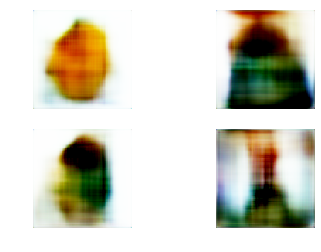

[Epoch 29/30] [Step 0/54] [D loss: 0.058473, acc:  95%] [G loss: 28.397673] time: 0:04:42.304277
[Epoch 29/30] [Step 1/54] [D loss: 0.034703, acc:  99%] [G loss: 30.459000] time: 0:04:42.465893
[Epoch 29/30] [Step 2/54] [D loss: 0.026047, acc:  99%] [G loss: 31.109289] time: 0:04:42.638558
[Epoch 29/30] [Step 3/54] [D loss: 0.076149, acc:  93%] [G loss: 27.533741] time: 0:04:42.804713
[Epoch 29/30] [Step 4/54] [D loss: 0.045570, acc:  96%] [G loss: 30.420969] time: 0:04:42.972230
[Epoch 29/30] [Step 5/54] [D loss: 0.029248, acc:  99%] [G loss: 32.342243] time: 0:04:43.137915
[Epoch 29/30] [Step 6/54] [D loss: 0.040457, acc:  96%] [G loss: 28.550848] time: 0:04:43.303230
[Epoch 29/30] [Step 7/54] [D loss: 0.034832, acc:  98%] [G loss: 35.585484] time: 0:04:43.467758
[Epoch 29/30] [Step 8/54] [D loss: 0.015939, acc: 100%] [G loss: 33.423519] time: 0:04:43.632872
[Epoch 29/30] [Step 9/54] [D loss: 0.016384, acc: 100%] [G loss: 28.097181] time: 0:04:43.799008
[Epoch 29/30] [Step 10/54] [D 

W0821 13:24:52.735060 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:52.737231 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:52.740565 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 13:24:52.744127 140050985047936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


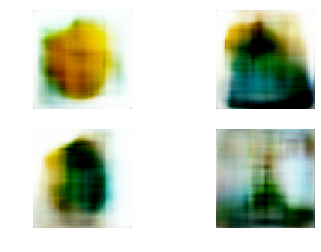

In [26]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.data_loader = DataLoader()


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        plot_model(self.discriminator, to_file='p2p_disc.png', show_shapes=True, show_layer_names=True)
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()
        plot_model(self.generator, to_file='p2p_gen.png', show_shapes=True, show_layer_names=True)

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape, name="img_A")
        img_B = Input(shape=self.img_shape, name="img_B")

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.summary()
        plot_model(self.combined, to_file='p2p_comb.png', show_shapes=True, show_layer_names=True)
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        def add_block(model, filters, block_id, decode = False):
            model.add(Conv2D(filters, kernel_size=3, padding="same", name=f"{block_id}_Conv2D"))
            model.add(BatchNormalization(momentum=0.8, name=f"{block_id}_BN"))
            model.add(LeakyReLU(alpha=0.2, name=f"{block_id}_Activation"))    
            if decode:
                model.add(UpSampling2D(name=f"{block_id}_Upsampling"))
            else:
                model.add(MaxPooling2D(name=f"{block_id}_Downsampling"))

        print("Building generator")

        model = Sequential(name="generator")

        # Encoding part
        model.add(Conv2D(self.gf, kernel_size=3, padding="same", input_shape=self.img_shape, name="Input_Conv2D"))
#         model.add(BatchNormalization(momentum=0.8, name="Input_BN"))
        model.add(LeakyReLU(alpha=0.2, name="Input_Activation"))    
        model.add(MaxPooling2D(name="Input_Downsampling"))

        add_block(model, self.gf * 2, 1)
        add_block(model, self.gf * 4, 2)
        add_block(model, self.gf * 8, 3)
        add_block(model, self.gf * 8, 4)
        add_block(model, self.gf * 8, 5)
        add_block(model, self.gf * 8, 6, True)

        # Decoding part
        add_block(model, self.gf * 8, 7, True)
        add_block(model, self.gf * 8, 8, True)
        add_block(model, self.gf * 4, 9, True)
        add_block(model, self.gf * 2, 10, True)
        add_block(model, self.gf, 11, True)

        model.add(Conv2D(3, kernel_size=3, padding="same", name="Output_Conv2D"))
        model.add(Activation("tanh", name="Output_Activation"))

        model.summary()
        plot_model(model, to_file='generator.png', show_shapes=True, show_layer_names=True)

        return model

    def build_discriminator(self):        
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        print("Building discriminator")

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity, name="Discriminator")


    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        steps_per_epoch = self.data_loader.files_count // batch_size

        for epoch in range(epochs):
            self.data_loader.reset()
            
            for step in range(steps_per_epoch):
                imgs_A, imgs_B = self.data_loader.load_batch(step, batch_size)
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Step %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        step, steps_per_epoch,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

            self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 2

        src = self.data_loader.load_test()
        fake = self.generator.predict(src)

        gen_imgs = np.concatenate([src, fake])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Generated']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(fake[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(f"{output_folder}/{epoch:03}")
        plt.show()
        plt.close()
        
gan = Pix2Pix()
gan.train(epochs=30, batch_size=10)